このノートでは、Autoencoderの基本概念を実装しています。Autoencoderは、入力画像の次元削減を行い、特徴量を覚えて、入力画像に近い画像を少ないデータで復元することができるモデルです。元々は次元削減するアイディアとして考案されました。

Autoencoderは特徴から元の画像を復元できる性質は、異常検知に使用されます。

データセットの作成
MNISTを使用

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# トランスフォームオブジェクトを生成
transform = transforms.Compose(
    [transforms.ToTensor(), # Tensorオブジェクトに変換
     nn.Flatten()]) # データの形状を(28, 28)から784,)に変換

# MNISTの訓練用データ
mnist_train = torchvision.datasets.MNIST(
    root='MNIST',
    download=True, # ダウンロードを許可
    train=True,    # 訓練データを指定
    transform=transform) # トランスフォームオブジェクト

# MNISTのテスト用データ
mnist_test = torchvision.datasets.MNIST(
    root='MNIST',
    download=True, # ダウンロードを許可
    train=False,   # テストデータを指定
    transform=transform) # トランスフォームオブジェクト

# データローダーを生成
train_dataloader = DataLoader(mnist_train,    # 訓練データ
                              batch_size=124, # ミニバッチのサイズ
                              shuffle=True)   # 抽出時にシャッフル
test_dataloader = DataLoader(mnist_test,     # テストデータ
                              batch_size=1,  # テストなので1
                              shuffle=False) # 抽出時にシャッフルしない


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:09<00:00, 1087589.19it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 160728.40it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1297067.04it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3601234.17it/s]

Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



type:<class 'tuple'>, data:torch.Size([1, 784]), label:5
最大値:1.0, 最小値:0.0


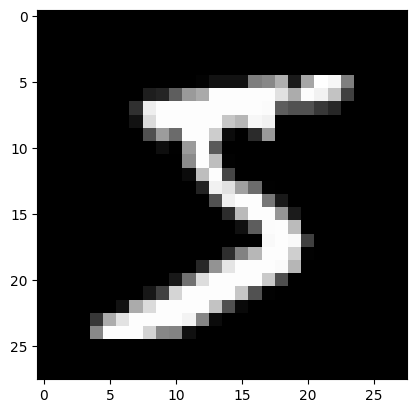

In [2]:
import matplotlib.pyplot as plt

_ = mnist_train[0]
print(f'type:{type(_)}, data:{_[0].shape}, label:{_[1]}')
print(f'最大値:{_[0].max()}, 最小値:{_[0].min()}')
plt.imshow(_[0].reshape(28, 28), cmap='gray')

Autoencoder モデルの作成とパラメータを設定

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Linear(784, 200) # エンコーダー(200ユニット)
        self.l2 = nn.Linear(200, 784) # デコーダー(784ユニット)

    def forward(self, x):
        h = self.l1(x)       # エンコーダーに入力
        h = torch.relu(h)    # ReLU関数を適用

        h = self.l2(h)       # デコーダーに入力
        y = torch.sigmoid(h) # シグモイド関数を適用
        return y


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

import torch.optim as optimizers

model = Autoencoder().to(device) # オートエンコーダーを生成
criterion = nn.BCELoss() # 損失関数はバイナリクロスエントロピー誤差
optimizer = optimizers.Adam(model.parameters()) # オプティマイザー（最適化関数）をAdamに設定


cpu


In [6]:
epochs = 10 # エポック数

# 学習の実行
for epoch in range(epochs):
    train_loss = 0.
    # ミニバッチのループ(ステップ)
    for (x, _) in train_dataloader:
        x = x.to(device) # デバイスの割り当て
        model.train()    # 訓練モードにする
        preds = model(x) # モデルの出力を取得
        loss = criterion(preds, x) # 入力xと復元predsの誤差を取得
        optimizer.zero_grad()      # 勾配を0で初期化
        loss.backward()  # 誤差の勾配を計算
        optimizer.step() # パラメーターの更新
        train_loss += loss.item() # 誤差(損失)の更新
    # 1エポックあたりの損失を求める
    train_loss /= len(train_dataloader)
    # 1エポックごとに損失を出力
    print('Epoch({}) -- Loss: {:.3f}'.format(
        epoch+1,
        train_loss
    ))


Epoch(1) -- Loss: 0.165
Epoch(2) -- Loss: 0.090
Epoch(3) -- Loss: 0.077
Epoch(4) -- Loss: 0.072
Epoch(5) -- Loss: 0.070
Epoch(6) -- Loss: 0.069
Epoch(7) -- Loss: 0.068
Epoch(8) -- Loss: 0.067
Epoch(9) -- Loss: 0.067
Epoch(10) -- Loss: 0.066


学習、推論の実行

In [7]:
epochs = 10 # エポック数

# 学習の実行
for epoch in range(epochs):
    train_loss = 0.
    # ミニバッチのループ(ステップ)
    for (x, _) in train_dataloader:
        x = x.to(device) # デバイスの割り当て
        model.train()    # 訓練モードにする
        preds = model(x) # モデルの出力を取得
        loss = criterion(preds, x) # 入力xと復元predsの誤差を取得
        optimizer.zero_grad()      # 勾配を0で初期化
        loss.backward()  # 誤差の勾配を計算
        optimizer.step() # パラメーターの更新
        train_loss += loss.item() # 誤差(損失)の更新
    # 1エポックあたりの損失を求める
    train_loss /= len(train_dataloader)
    # 1エポックごとに損失を出力
    print('Epoch({}) -- Loss: {:.3f}'.format(
        epoch+1,
        train_loss
    ))

Epoch(1) -- Loss: 0.066
Epoch(2) -- Loss: 0.066
Epoch(3) -- Loss: 0.066
Epoch(4) -- Loss: 0.065
Epoch(5) -- Loss: 0.065
Epoch(6) -- Loss: 0.065
Epoch(7) -- Loss: 0.065
Epoch(8) -- Loss: 0.065
Epoch(9) -- Loss: 0.065
Epoch(10) -- Loss: 0.065


学習後、入力画像から出力画像を復元してみる

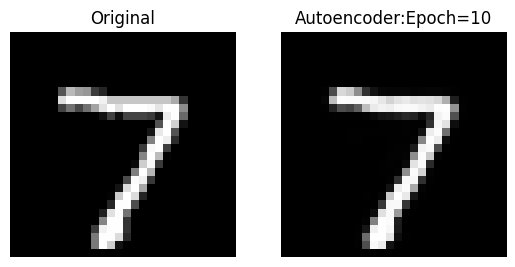

In [8]:
import matplotlib.pyplot as plt

# テストデータを1個取り出す
_x, _ = next(iter(test_dataloader))
_x = _x.to(device)

model.eval() # ネットワークを評価モードにする
x_rec = model(_x) # テストデータを入力して結果を取得

# 入力画像、復元画像を表示
titles = {0: 'Original', 1: 'Autoencoder:Epoch=10'}
for i, image in enumerate([_x, x_rec]):
    image = image.view(28, 28).detach().cpu().numpy()
    plt.subplot(1, 2, i+1)
    plt.imshow(image, cmap='binary_r')
    plt.axis('off'), plt.title(titles[i])
plt.show()